
Training Configuration 1
Epoch 1, Loss: 37.2546
Epoch 2, Loss: 33.8465
Epoch 3, Loss: 33.7857
Epoch 4, Loss: 33.7475
Epoch 5, Loss: 33.7158
Test Loss: 33.2980


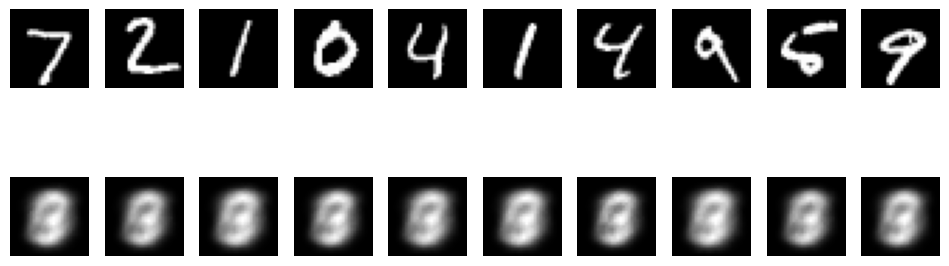


Training Configuration 2


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1, Loss: 37.2735
Epoch 2, Loss: 33.8406
Epoch 3, Loss: 33.7925
Epoch 4, Loss: 33.7593
Epoch 5, Loss: 33.7305
Test Loss: 33.3170


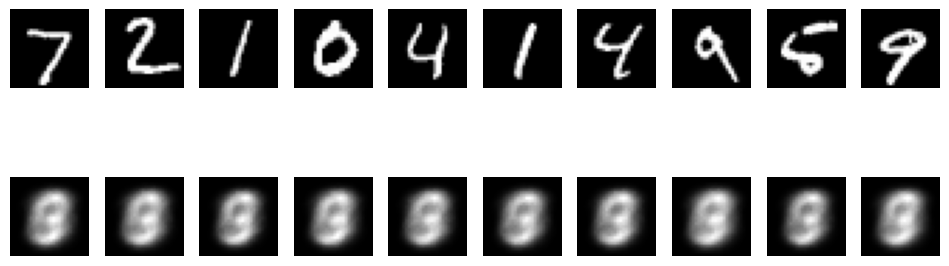


Training Configuration 3
Epoch 1, Loss: 37.6533
Epoch 2, Loss: 33.7912
Epoch 3, Loss: 33.7475
Epoch 4, Loss: 33.7298
Epoch 5, Loss: 33.7076
Test Loss: 33.2818


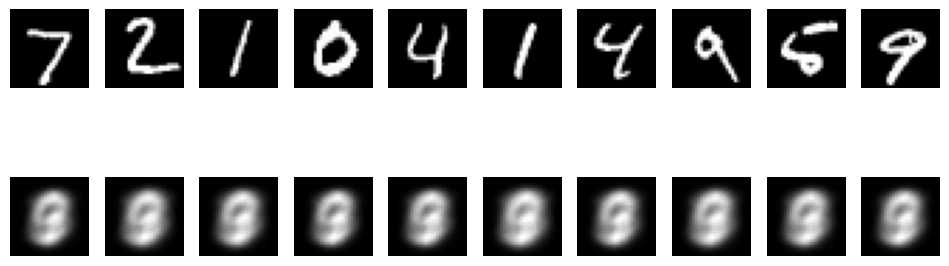

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

class EncoderDecoder(tf.keras.Model):
    def __init__(self, input_dim, hidden_dims):
        super(EncoderDecoder, self).__init__()
        self.encoder = models.Sequential([
            layers.Dense(dim, activation='relu') for dim in hidden_dims
        ])
        self.decoder = models.Sequential([
            layers.Dense(dim, activation='relu') for dim in hidden_dims
        ] + [layers.Dense(input_dim, activation='sigmoid')])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded, encoded

class VAE(tf.keras.Model):
    def __init__(self, input_dim, latent_dim, enc_dec_config):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Left side (encoder-replacement)
        if enc_dec_config['encoder']:
            self.left = EncoderDecoder(input_dim, enc_dec_config['encoder_hidden_dims'])
        else:
            self.encoder = models.Sequential([
                layers.Dense(128, activation='relu'),
                layers.Dense(64, activation='relu')
            ])
            self.fc_mu = layers.Dense(latent_dim)
            self.fc_logvar = layers.Dense(latent_dim)

        # Right side (decoder-replacement)
        if enc_dec_config['decoder']:
            self.right = EncoderDecoder(input_dim, enc_dec_config['decoder_hidden_dims'])
        else:
            self.decoder = models.Sequential([
                layers.Dense(64, activation='relu'),
                layers.Dense(128, activation='relu'),
                layers.Dense(input_dim, activation='sigmoid')
            ])

    def encode(self, x):
        if hasattr(self, 'left'):
            _, encoded = self.left(x)
            mu, logvar = tf.split(encoded, num_or_size_splits=2, axis=1)  # Assuming split latent representation
        else:
            h = self.encoder(x)
            mu = self.fc_mu(h)
            logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + eps * tf.exp(0.5 * logvar)

    def decode(self, z):
        if hasattr(self, 'right'):
            decoded, _ = self.right(z)
        else:
            decoded = self.decoder(z)
        return decoded

    def call(self, inputs):
        mu, logvar = self.encode(inputs)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# Training and Testing
class VAETrainer:
    def __init__(self, model, train_data, test_data):
        self.model = model
        self.train_data = train_data
        self.test_data = test_data
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    def vae_loss(self, x, recon_x, mu, logvar):
        recon_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, recon_x))
        kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))
        return recon_loss + kl_loss

    def train_step(self, x):
        with tf.GradientTape() as tape:
            recon_x, mu, logvar = self.model(x)
            loss = self.vae_loss(x, recon_x, mu, logvar)
        grads = tape.gradient(loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        return loss

    def train(self, epochs=10):
        for epoch in range(epochs):
            train_loss = 0
            for x in self.train_data:
                train_loss += self.train_step(x).numpy()
            print(f"Epoch {epoch + 1}, Loss: {train_loss / len(self.train_data):.4f}")

    def evaluate(self):
        total_loss = 0
        for x in self.test_data:
            recon_x, mu, logvar = self.model(x)
            total_loss += self.vae_loss(x, recon_x, mu, logvar).numpy()
        print(f"Test Loss: {total_loss / len(self.test_data):.4f}")

    def visualize_reconstructions(self):
        for x in self.test_data:
            recon_x, _, _ = self.model(x)
            x = tf.reshape(x, [-1, 28, 28]).numpy()
            recon_x = tf.reshape(recon_x, [-1, 28, 28]).numpy()
            break

        # Plot Original and Reconstructed Images
        fig, axes = plt.subplots(2, 10, figsize=(12, 4))
        for i in range(10):
            axes[0, i].imshow(x[i], cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(recon_x[i], cmap='gray')
            axes[1, i].axis('off')
        plt.show()

# Data Loaders
def get_data_loaders(batch_size=128):
    (x_train, _), (x_test, _) = mnist.load_data()
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = x_train.reshape(-1, 28 * 28)
    x_test = x_test.reshape(-1, 28 * 28)

    train_data = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size)
    test_data = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size)

    return train_data, test_data


# Main Function
def main():
    # Data Loaders
    train_data, test_data = get_data_loaders()

    # Configurations for different models
    configs = [
        {'encoder': False, 'decoder': False, 'encoder_hidden_dims': [], 'decoder_hidden_dims': []},
        {'encoder': True, 'decoder': False, 'encoder_hidden_dims': [256, 128], 'decoder_hidden_dims': []},
        {'encoder': True, 'decoder': True, 'encoder_hidden_dims': [256, 128], 'decoder_hidden_dims': [128,64]}
    ]

    # Train and Evaluate each configuration
    for idx, config in enumerate(configs):
        print(f"\nTraining Configuration {idx + 1}")
        model = VAE(input_dim=28 * 28, latent_dim=32, enc_dec_config=config)
        trainer = VAETrainer(model, train_data, test_data)
        trainer.train(epochs=5)
        trainer.evaluate()
        trainer.visualize_reconstructions()

main()
